In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# Image Processing
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Model Building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Data Balancing
from imblearn.over_sampling import RandomOverSampler

# Visualization Style
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

In [3]:
# Load metadata
data = pd.read_csv('/kaggle/input/isic-2019-skin-lesion-images-for-classification/ISIC_2019_Training_GroundTruth.csv')
print("Data Shape:", data.shape)

# Check image folder structure
dataset_path = '/kaggle/input/isic-2019-skin-lesion-images-for-classification/'
print(os.listdir(dataset_path))

Data Shape: (25331, 10)
['MEL', 'VASC', 'SCC', 'DF', 'NV', 'ISIC_2019_Training_GroundTruth.csv', 'ISIC_2019_Training_Metadata.csv', 'BKL', 'BCC', 'AK']


In [4]:
def load_and_resize_images(image_paths, target_size=(32, 32)):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)  # Load and resize
        img_array = img_to_array(img)  # Convert to array
        images.append(img_array)
    return np.array(images)

In [4]:
# Define classes
class_folders = ['MEL', 'VASC', 'SCC', 'DF', 'NV', 'BKL', 'BCC', 'AK']

# Load images and labels
all_images, all_labels = [], []

for class_name in class_folders:
    class_folder_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_folder_path)
    class_images = load_and_resize_images([os.path.join(class_folder_path, img) for img in image_files])
    all_images.append(class_images)
    all_labels.append([class_name] * len(image_files))

# Combine all data
X_all = np.concatenate(all_images, axis=0)
y_all = np.concatenate(all_labels, axis=0)

print("Shape of all images:", X_all.shape)
print("Shape of all labels:", y_all.shape)

Shape of all images: (25331, 32, 32, 3)
Shape of all labels: (25331,)


In [5]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_all)
y_one_hot = to_categorical(y_encoded)

# Reshape data for oversampling
X_reshaped = X_all.reshape(X_all.shape[0], -1)
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_reshaped, y_one_hot)

print("Class distribution after oversampling:", Counter(np.argmax(y_resampled, axis=1)))

Class distribution after oversampling: Counter({4: 12875, 7: 12875, 6: 12875, 3: 12875, 5: 12875, 2: 12875, 1: 12875, 0: 12875})


In [6]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print(f"Shapes - X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

Shapes - X_train: (82400, 3072), X_test: (20600, 3072), y_train: (82400, 8), y_test: (20600, 8)


In [7]:
# Reshape to (28, 28, 3)
X_train_reshaped = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_test_reshaped = X_test.reshape(X_test.shape[0], 32, 32, 3)

In [8]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

Epoch 1/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 113s 50ms/step - accuracy: 0.4148 - loss: 1.6695 - val_accuracy: 0.3265 - val_loss: 2.3184
Epoch 2/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.6508 - loss: 0.9326 - val_accuracy: 0.5751 - val_loss: 1.2408
Epoch 3/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.7286 - loss: 0.7353 - val_accuracy: 0.4647 - val_loss: 1.8022
Epoch 4/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.7246 - loss: 0.7533 - val_accuracy: 0.3995 - val_loss: 1.6801
Epoch 5/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.6665 - loss: 0.9005 - val_accuracy: 0.6363 - val_loss: 1.0717
Epoch 6/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.8249 - loss: 0.4769 - val_accuracy: 0.5235 - val_loss: 1.7811
Epoch 7/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.8634 - loss: 0.3764 - val_accuracy: 0.8186 - val_loss: 0.5313
Epoch 8/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.8874 

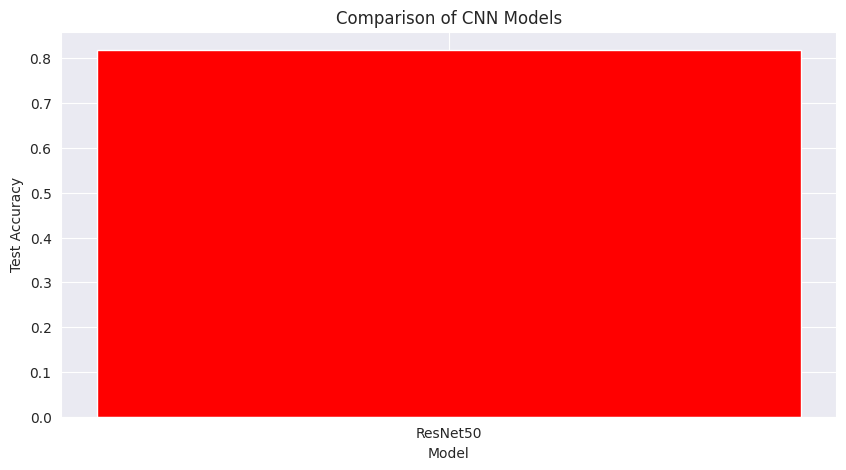

In [18]:
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
]
# Define input shape
input_shape = (32, 32, 3)
num_classes = 8  # Adjust based on your dataset

# Load Pretrained Models

def build_resnet50():
    base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Train and Evaluate Models
def train_and_evaluate(model, name):
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test),
                        epochs=10, batch_size=64, callbacks=callbacks)
    test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=1)
    print(f"{name} Test Accuracy: {test_accuracy * 100:.2f}%")
    return history, test_accuracy

# Train models
models = {
    "ResNet50": build_resnet50(),
}

histories, accuracies = {}, {}
for name, model in models.items():
    histories[name], accuracies[name] = train_and_evaluate(model, name)

# Plot Comparison
plt.figure(figsize=(10, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=['red', 'blue', 'green', 'purple'])
plt.xlabel("Model")
plt.ylabel("Test Accuracy")
plt.title("Comparison of CNN Models")
plt.show()


Epoch 1/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 112s 50ms/step - accuracy: 0.4261 - loss: 1.5939 - val_accuracy: 0.4614 - val_loss: 1.5784
Epoch 2/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.6681 - loss: 0.8972 - val_accuracy: 0.5458 - val_loss: 1.4305
Epoch 3/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.7487 - loss: 0.6859 - val_accuracy: 0.4755 - val_loss: 1.8344
Epoch 4/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.8003 - loss: 0.5424 - val_accuracy: 0.5846 - val_loss: 1.4550
Epoch 5/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.8291 - loss: 0.4732 - val_accuracy: 0.6191 - val_loss: 1.2460
Epoch 6/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.8495 - loss: 0.4251 - val_accuracy: 0.6520 - val_loss: 1.0058
Epoch 7/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.8698 - loss: 0.3653 - val_accuracy: 0.7933 - val_loss: 0.6376
Epoch 8/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.9024 

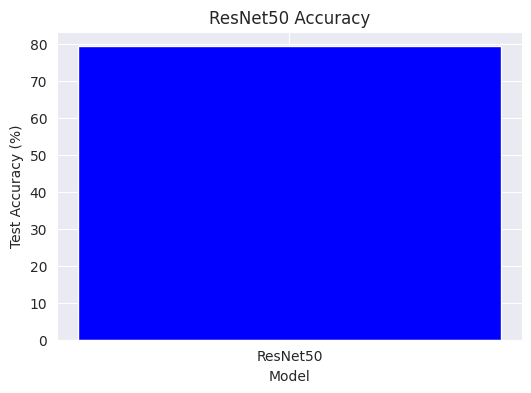

In [9]:
import json
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define callback
callbacks = [EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]

# Define input shape & number of classes
input_shape = (32, 32, 3)
num_classes = 8  # Adjust based on your dataset

# Build ResNet50 Model
def build_resnet50():
    base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Train & Save Model
def train_and_save(model, model_name="ResNet50"):
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test),
                        epochs=10, batch_size=64, callbacks=callbacks)
    
    test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=1)
    print(f"{model_name} Test Accuracy: {test_accuracy * 100:.2f}%")

    # Save model
    model.save(f"{model_name}.h5")

    # Save training history and accuracy in JSON
    history_dict = history.history
    history_dict["test_accuracy"] = test_accuracy  # Store test accuracy separately

    with open(f"{model_name}_history.json", "w") as f:
        json.dump(history_dict, f)

    return history, test_accuracy

# Train and Save ResNet50
model = build_resnet50()
history, accuracy = train_and_save(model)

# Save Accuracy Separately
accuracy_data = {"ResNet50": accuracy}
with open("model_accuracies.json", "w") as f:
    json.dump(accuracy_data, f)

# Plot & Save Accuracy Graph
plt.figure(figsize=(6, 4))
plt.bar(["ResNet50"], [accuracy * 100], color="blue")
plt.xlabel("Model")
plt.ylabel("Test Accuracy (%)")
plt.title("ResNet50 Accuracy")
plt.savefig("resnet50_accuracy.png")  # Save plot as an image file
plt.show()


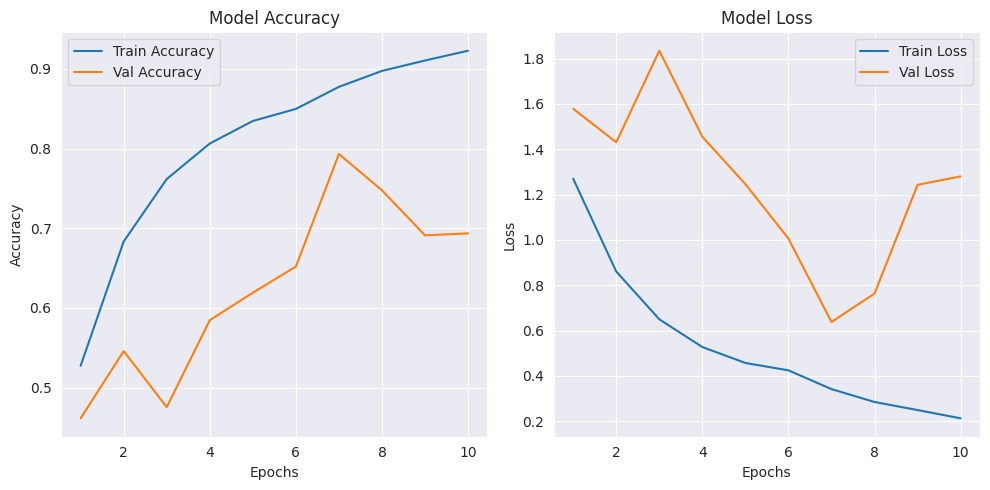

NameError: name 'plot_confusion_matrix' is not defined

In [15]:
plot_model_history(history)
plot_confusion_matrix(model, X_test_reshaped, y_test, label_encoder)


In [14]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot Accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'], label="Train Accuracy")
    axs[0].plot(range(1, len(model_history.history['val_accuracy']) + 1), model_history.history['val_accuracy'], label="Val Accuracy")
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # Plot Loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'], label="Train Loss")
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'], label="Val Loss")
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

644/644 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step


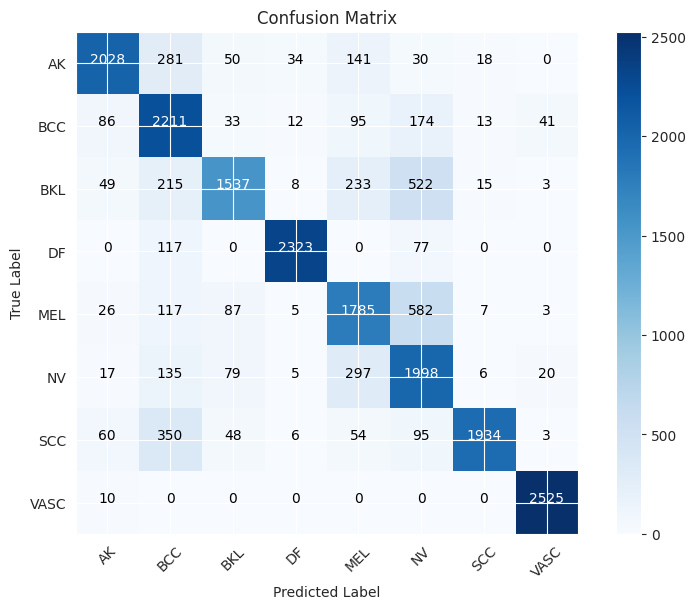

In [17]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else int(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Predictions
Y_pred = model.predict(X_test_reshaped)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(cm, classes=label_encoder.classes_)


inceptionNET-----------------------

In [5]:
def load_and_resize_images(image_paths, target_size=(75, 75)):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)  # Load and resize
        img_array = img_to_array(img)  # Convert to array
        images.append(img_array)
    return np.array(images)

In [6]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# Image Processing
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Model Building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define classes
class_folders = ['MEL', 'VASC', 'SCC', 'DF', 'NV', 'BKL', 'BCC', 'AK']

# Load images and labels
all_images, all_labels = [], []

for class_name in class_folders:
    class_folder_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_folder_path)
    class_images = load_and_resize_images([os.path.join(class_folder_path, img) for img in image_files])
    all_images.append(class_images)
    all_labels.append([class_name] * len(image_files))

# Combine all data
X_all = np.concatenate(all_images, axis=0)
y_all = np.concatenate(all_labels, axis=0)

print("Shape of all images:", X_all.shape)
print("Shape of all labels:", y_all.shape)

Shape of all images: (25331, 75, 75, 3)
Shape of all labels: (25331,)


In [7]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_all)
y_one_hot = to_categorical(y_encoded)

# Reshape data for oversampling
X_reshaped = X_all.reshape(X_all.shape[0], -1)
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_reshaped, y_one_hot)

print("Class distribution after oversampling:", Counter(np.argmax(y_resampled, axis=1)))

Class distribution after oversampling: Counter({4: 12875, 7: 12875, 6: 12875, 3: 12875, 5: 12875, 2: 12875, 1: 12875, 0: 12875})


In [8]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print(f"Shapes - X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

Shapes - X_train: (82400, 16875), X_test: (20600, 16875), y_train: (82400, 8), y_test: (20600, 8)


In [9]:
# Reshape to (28, 28, 3)
X_train_reshaped = X_train.reshape(X_train.shape[0], 75, 75, 3)
X_test_reshaped = X_test.reshape(X_test.shape[0], 75, 75, 3)

In [10]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

Epoch 1/5
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 179s 92ms/step - accuracy: 0.4012 - loss: 1.5968 - val_accuracy: 0.4916 - val_loss: 1.4852
Epoch 2/5
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 79s 61ms/step - accuracy: 0.6213 - loss: 1.0323 - val_accuracy: 0.5679 - val_loss: 1.2831
Epoch 3/5
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 79s 62ms/step - accuracy: 0.7101 - loss: 0.7894 - val_accuracy: 0.4963 - val_loss: 1.5681
Epoch 4/5
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 79s 62ms/step - accuracy: 0.7497 - loss: 0.6791 - val_accuracy: 0.5399 - val_loss: 1.4667
Epoch 5/5
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 79s 61ms/step - accuracy: 0.7676 - loss: 0.6426 - val_accuracy: 0.6463 - val_loss: 1.1391
644/644 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.6443 - loss: 1.1371
InceptionV1 Test Accuracy: 64.63%


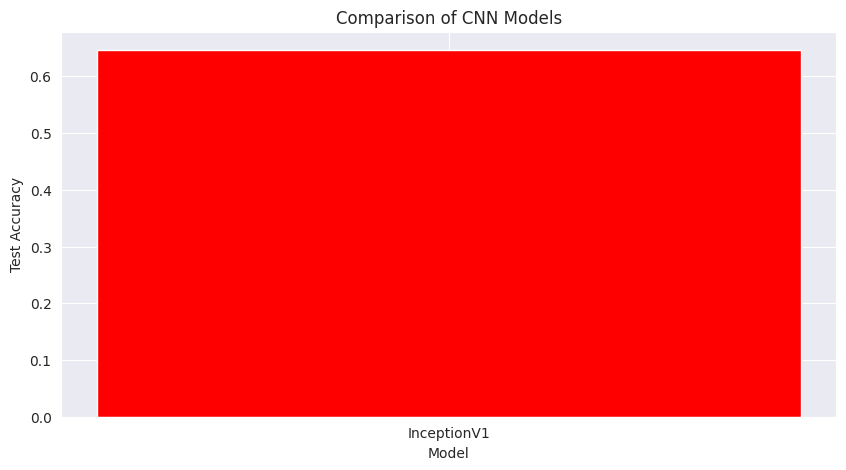

In [10]:
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
]
# Define input shape
input_shape = (75, 75, 3)
num_classes = 8  # Adjust based on your dataset

# Load Pretrained Models
def build_inception_v1():
    base_model = InceptionV3(weights=None, include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model






# Train and Evaluate Models
def train_and_evaluate(model, name):
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test),
                        epochs=5, batch_size=64, callbacks=callbacks)
    test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=1)
    print(f"{name} Test Accuracy: {test_accuracy * 100:.2f}%")
    return history, test_accuracy

# Train models
models = {
    "InceptionV1": build_inception_v1(),
}

histories, accuracies = {}, {}
for name, model in models.items():
    histories[name], accuracies[name] = train_and_evaluate(model, name)

# Plot Comparison
plt.figure(figsize=(10, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=['red', 'blue', 'green', 'purple'])
plt.xlabel("Model")
plt.ylabel("Test Accuracy")
plt.title("Comparison of CNN Models")
plt.show()

Epoch 1/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 175s 90ms/step - accuracy: 0.4112 - loss: 1.5762 - val_accuracy: 0.4190 - val_loss: 1.8846
Epoch 2/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 77s 59ms/step - accuracy: 0.6294 - loss: 1.0173 - val_accuracy: 0.1292 - val_loss: 40.4296
Epoch 3/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 77s 60ms/step - accuracy: 0.5965 - loss: 1.0911 - val_accuracy: 0.6085 - val_loss: 1.1889
Epoch 4/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 76s 59ms/step - accuracy: 0.7701 - loss: 0.6274 - val_accuracy: 0.6508 - val_loss: 0.9878
Epoch 5/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 76s 59ms/step - accuracy: 0.7332 - loss: 0.7275 - val_accuracy: 0.7786 - val_loss: 0.6032
Epoch 6/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 76s 59ms/step - accuracy: 0.7553 - loss: 0.6733 - val_accuracy: 0.7950 - val_loss: 0.5705
Epoch 7/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 76s 59ms/step - accuracy: 0.8306 - loss: 0.4595 - val_accuracy: 0.8110 - val_loss: 0.5450
Epoch 8/10
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 76s 59ms/step - accuracy: 0.8834

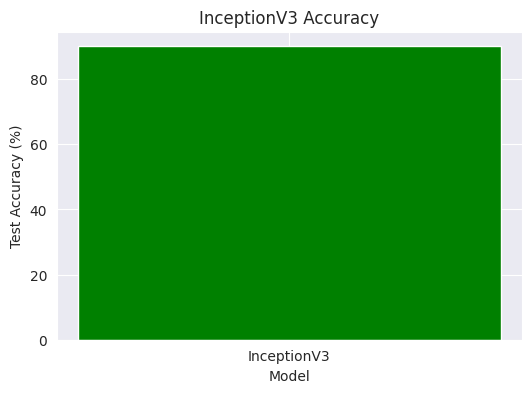

In [11]:
import json
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define callback
callbacks = [EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)]

# Define input shape & number of classes
input_shape = (75, 75, 3)
num_classes = 8  # Adjust based on your dataset

# Build InceptionV3 Model
def build_inception_v3():
    base_model = InceptionV3(weights=None, include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Train & Save Model
def train_and_save(model, model_name="InceptionV3"):
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test),
                        epochs=10, batch_size=64, callbacks=callbacks)
    
    test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=1)
    print(f"{model_name} Test Accuracy: {test_accuracy * 100:.2f}%")

    # Save model
    model.save(f"{model_name}.h5")

    # Save training history and accuracy in JSON
    history_dict = history.history
    history_dict["test_accuracy"] = test_accuracy  # Store test accuracy separately

    with open(f"{model_name}_history.json", "w") as f:
        json.dump(history_dict, f)

    return history, test_accuracy

# Train and Save InceptionV3
model = build_inception_v3()
history, accuracy = train_and_save(model, "InceptionV3")

# Save Accuracy Separately
accuracy_data = {"InceptionV3": accuracy}
with open("model_accuracies.json", "w") as f:
    json.dump(accuracy_data, f)

# Plot & Save Accuracy Graph
plt.figure(figsize=(6, 4))
plt.bar(["InceptionV3"], [accuracy * 100], color="green")
plt.xlabel("Model")
plt.ylabel("Test Accuracy (%)")
plt.title("InceptionV3 Accuracy")
plt.savefig("inceptionv3_accuracy.png")  # Save plot as an image file
plt.show()


In [13]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot Accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'], label="Train Accuracy")
    axs[0].plot(range(1, len(model_history.history['val_accuracy']) + 1), model_history.history['val_accuracy'], label="Val Accuracy")
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # Plot Loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'], label="Train Loss")
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'], label="Val Loss")
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

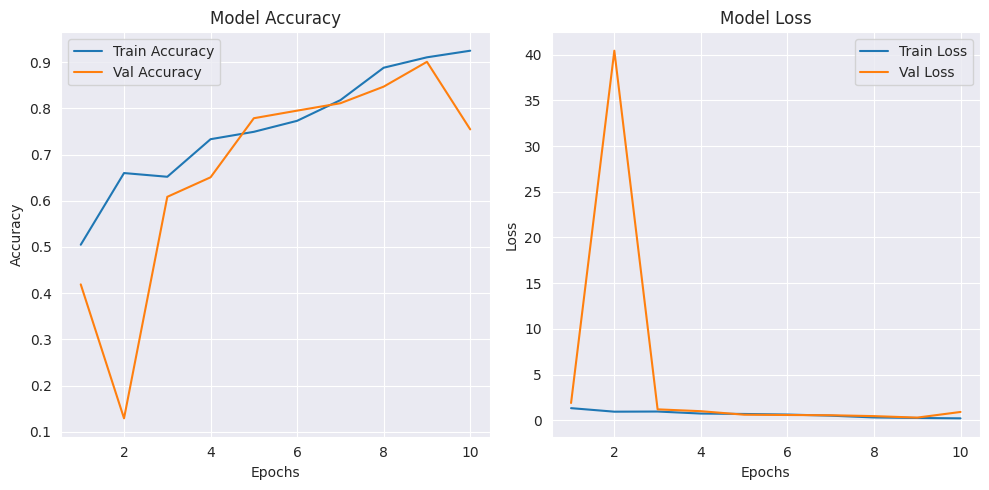

NameError: name 'plot_confusion_matrix' is not defined

In [14]:
plot_model_history(history)
plot_confusion_matrix(model, X_test_reshaped, y_test, label_encoder)

644/644 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step


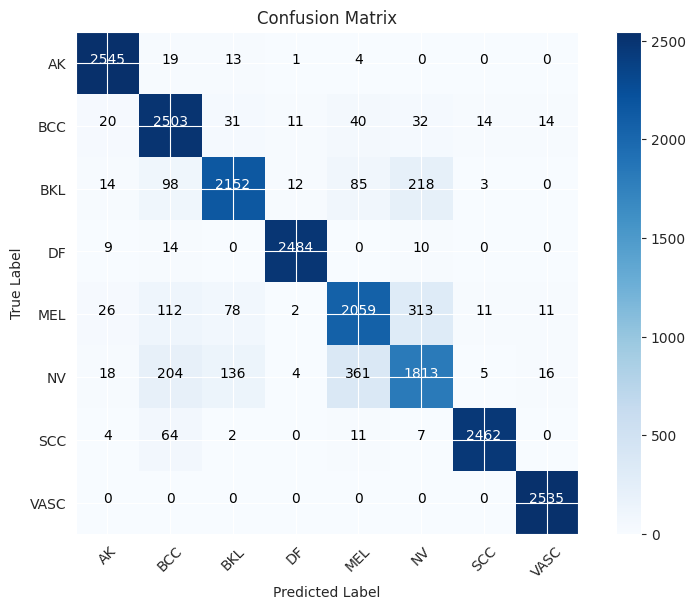

In [15]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else int(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Predictions
Y_pred = model.predict(X_test_reshaped)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(cm, classes=label_encoder.classes_)


ALEXNET_______________________

In [3]:
def load_and_resize_images(image_paths, target_size=(128, 128)):  # Resize correctly for AlexNet
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)  # Resize the image
        img_array = img_to_array(img)  # Convert to array
        images.append(img_array)
    return np.array(images)


In [4]:
# Define classes
class_folders = ['MEL', 'VASC', 'SCC', 'DF', 'NV', 'BKL', 'BCC', 'AK']
# Load images and labels
all_images, all_labels = [], []

for class_name in class_folders:
    class_folder_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_folder_path)
    class_images = load_and_resize_images([os.path.join(class_folder_path, img) for img in image_files], target_size=(128, 128))
    all_images.append(class_images)
    all_labels.append([class_name] * len(image_files))

# Combine all data
X_all = np.concatenate(all_images, axis=0)
y_all = np.concatenate(all_labels, axis=0)

print("Shape of all images:", X_all.shape)  # Should be (total_images, 227, 227, 3)
print("Shape of all labels:", y_all.shape)



Shape of all images: (25331, 128, 128, 3)
Shape of all labels: (25331,)


In [5]:
# Now the images are correctly sized, and we can proceed with splitting
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# No need to reshape manually, as images are already (227, 227, 3)
print(f"Shapes - X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

Shapes - X_train: (20264, 128, 128, 3), X_test: (5067, 128, 128, 3), y_train: (20264,), y_test: (5067,)


In [6]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [7]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_alexnet(input_shape=(128, 128, 3), num_classes=8):  
    model = Sequential([
        Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),  # Modify kernel size if needed
        MaxPooling2D((3, 3), strides=(2, 2)),
        
        Conv2D(256, (5, 5), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=(2, 2)),
        
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=(2, 2)),
        
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [8]:
# Build the model
alexnet_model = build_alexnet()
alexnet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 6, 6, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 6, 6, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │       4,198,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │          32,776 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,759,688 (94.45 MB)

 Trainable params: 24,759,688 (94.45 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Convert class labels (strings) to numeric values
label_encoder = LabelEncoder()
y_all_numeric = label_encoder.fit_transform(y_all)  # Convert string labels to numbers

# Split Data (Ensure you already have X_train, X_test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all_numeric, test_size=0.2, random_state=42)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=8)
y_test = to_categorical(y_test, num_classes=8)

# Verify shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (20264, 128, 128, 3)
y_train shape: (20264, 8)
X_test shape: (5067, 128, 128, 3)
y_test shape: (5067, 8)


Epoch 1/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.4834 - loss: 5.3182 - val_accuracy: 0.5443 - val_loss: 1.2589
Epoch 2/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5538 - loss: 1.2567 - val_accuracy: 0.5502 - val_loss: 1.2360
Epoch 3/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5673 - loss: 1.2306 - val_accuracy: 0.5481 - val_loss: 1.2722
Epoch 4/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5664 - loss: 1.2223 - val_accuracy: 0.5690 - val_loss: 1.2051
Epoch 5/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5718 - loss: 1.2119 - val_accuracy: 0.5788 - val_loss: 1.1768
Epoch 6/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5857 - loss: 1.1885 - val_accuracy: 0.5836 - val_loss: 1.1695
Epoch 7/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5844 - loss: 1.1795 - val_accuracy: 0.5777 - val_loss: 1.1695
Epoch 8/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5800 - loss: 1.1869 - val_acc

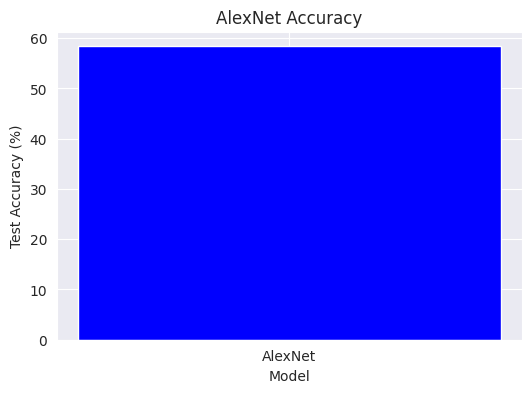

In [10]:
# Define callback
callbacks = [EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)]
# Reshape to (28, 28, 3)
X_train_reshaped = X_train.reshape(X_train.shape[0], 128, 128, 3)
X_test_reshaped = X_test.reshape(X_test.shape[0], 128, 128, 3)# Train & Save Model

def train_and_save(model, model_name="AlexNet"):
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test),
                        epochs=10, batch_size=64, callbacks=callbacks)
    
    test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=1)
    print(f"{model_name} Test Accuracy: {test_accuracy * 100:.2f}%")

    # Save model
    model.save(f"{model_name}.h5")

    # Save training history and accuracy in JSON
    history_dict = history.history
    history_dict["test_accuracy"] = test_accuracy  # Store test accuracy separately

    with open(f"{model_name}_history.json", "w") as f:
        json.dump(history_dict, f)

    return history, test_accuracy

# Train and Save AlexNet
alexnet_model = build_alexnet()
history, accuracy = train_and_save(alexnet_model, "AlexNet")

# Save Accuracy Separately
accuracy_data = {"AlexNet": accuracy}
with open("model_accuracies.json", "w") as f:
    json.dump(accuracy_data, f)

# Plot & Save Accuracy Graph
plt.figure(figsize=(6, 4))
plt.bar(["AlexNet"], [accuracy * 100], color="blue")
plt.xlabel("Model")
plt.ylabel("Test Accuracy (%)")
plt.title("AlexNet Accuracy")
plt.savefig("alexnet_accuracy.png")  # Save plot as an image file
plt.show()

In [17]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot Accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'], label="Train Accuracy")
    axs[0].plot(range(1, len(model_history.history['val_accuracy']) + 1), model_history.history['val_accuracy'], label="Val Accuracy")
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # Plot Loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'], label="Train Loss")
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'], label="Val Loss")
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.savefig("alexnet_training_history.png")  # Save plot as image file
    plt.show()


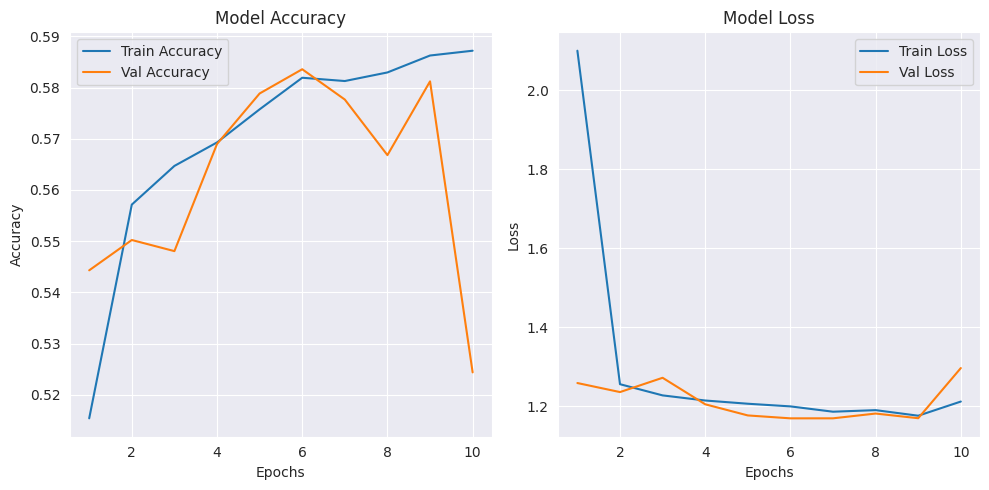

In [18]:
plot_model_history(history)


In [19]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("alexnet_confusion_matrix.png")
    plt.show()


In [21]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else int(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


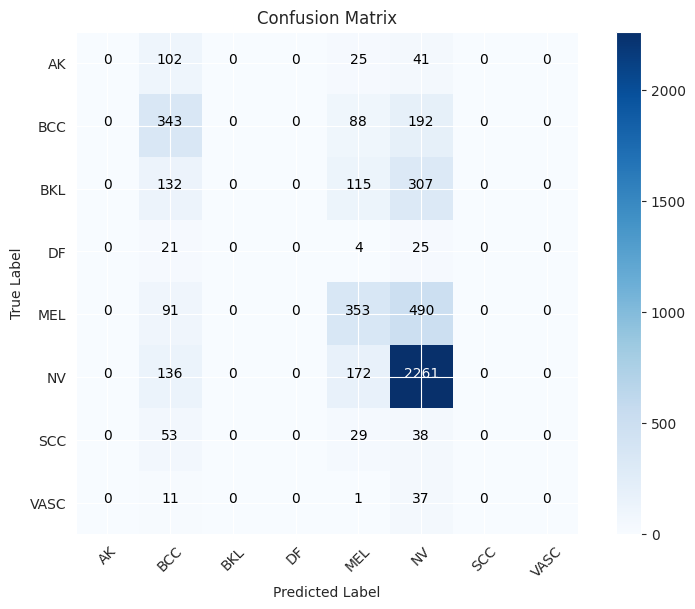

In [22]:
# Predictions
Y_pred = alexnet_model.predict(X_test_reshaped)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

# Plot confusion matrix using label_encoder for class names
plot_confusion_matrix(cm, classes=label_encoder.classes_)

googlenet---

In [4]:
def load_and_resize_images(image_paths, target_size=(75, 75)):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)  # Load and resize
        img_array = img_to_array(img)  # Convert to array
        images.append(img_array)
    return np.array(images)

GOOGLENET

In [5]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# Image Processing
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Model Building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define classes
class_folders = ['MEL', 'VASC', 'SCC', 'DF', 'NV', 'BKL', 'BCC', 'AK']

# Load images and labels
all_images, all_labels = [], []

for class_name in class_folders:
    class_folder_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_folder_path)
    class_images = load_and_resize_images([os.path.join(class_folder_path, img) for img in image_files])
    all_images.append(class_images)
    all_labels.append([class_name] * len(image_files))

# Combine all data
X_all = np.concatenate(all_images, axis=0)
y_all = np.concatenate(all_labels, axis=0)

print("Shape of all images:", X_all.shape)
print("Shape of all labels:", y_all.shape)

Shape of all images: (25331, 75, 75, 3)
Shape of all labels: (25331,)


In [6]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_all)
y_one_hot = to_categorical(y_encoded)

# Reshape data for oversampling
X_reshaped = X_all.reshape(X_all.shape[0], -1)
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_reshaped, y_one_hot)

print("Class distribution after oversampling:", Counter(np.argmax(y_resampled, axis=1)))

Class distribution after oversampling: Counter({4: 12875, 7: 12875, 6: 12875, 3: 12875, 5: 12875, 2: 12875, 1: 12875, 0: 12875})


In [10]:
# Now the images are correctly sized, and we can proceed with splitting
#X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_one_hot, test_size=0.2, random_state=42)

# No need to reshape manually, as images are already (227, 227, 3)
print(f"Shapes - X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

Shapes - X_train: (20264, 75, 75, 3), X_test: (5067, 75, 75, 3), y_train: (20264, 8), y_test: (5067, 8)


In [11]:
# Reshape to (28, 28, 3)
X_train_reshaped = X_train.reshape(X_train.shape[0], 75, 75, 3)
X_test_reshaped = X_test.reshape(X_test.shape[0], 75, 75, 3)

Epoch 1/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 85s 143ms/step - accuracy: 0.4743 - loss: 1.6115 - val_accuracy: 0.5425 - val_loss: 1.2492
Epoch 2/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.5531 - loss: 1.2248 - val_accuracy: 0.5810 - val_loss: 1.1791
Epoch 3/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.5795 - loss: 1.1701 - val_accuracy: 0.5583 - val_loss: 1.1976
Epoch 4/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.5919 - loss: 1.1395 - val_accuracy: 0.5850 - val_loss: 1.1451
Epoch 5/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.6058 - loss: 1.1175 - val_accuracy: 0.5980 - val_loss: 1.0905
Epoch 6/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.6083 - loss: 1.0981 - val_accuracy: 0.6082 - val_loss: 1.0761
Epoch 7/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.6234 - loss: 1.0744 - val_accuracy: 0.6106 - val_loss: 1.1444
Epoch 8/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.6242 - loss: 1.0614 -

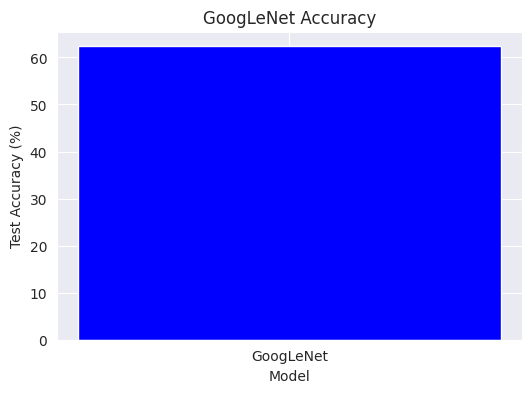

In [12]:
import json
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, AveragePooling2D,
                                     Flatten, Dense, Dropout, concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define callback
callbacks = [EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)]

# Input shape and number of classes
input_shape = (75, 75, 3)
num_classes = 8  # Change based on your dataset

# GoogLeNet Inception module
def inception_module(x, filters):
    conv1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    conv3 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3)

    conv5 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5)

    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(pool)

    output = concatenate([conv1, conv3, conv5, pool], axis=3)
    return output

# Build GoogLeNet (InceptionV1-style)
def build_googlenet(input_shape=(75, 75, 3), num_classes=8):
    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Inception modules
    x = inception_module(x, [64, 96, 128, 16, 32, 32])
    x = inception_module(x, [128, 128, 192, 32, 96, 64])
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [192, 96, 208, 16, 48, 64])
    x = inception_module(x, [160, 112, 224, 24, 64, 64])
    x = inception_module(x, [128, 128, 256, 24, 64, 64])
    x = inception_module(x, [112, 144, 288, 32, 64, 64])
    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = inception_module(x, [384, 192, 384, 48, 128, 128])

    x = AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid')(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=x)
    return model

# Train & Save Model
def train_and_save(model, model_name="GoogLeNet"):
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test),
                        epochs=10, batch_size=64, callbacks=callbacks)
    
    test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=1)
    print(f"{model_name} Test Accuracy: {test_accuracy * 100:.2f}%")

    # Save model
    model.save(f"{model_name}.h5")

    # Save training history and accuracy in JSON
    history_dict = history.history
    history_dict["test_accuracy"] = test_accuracy

    with open(f"{model_name}_history.json", "w") as f:
        json.dump(history_dict, f)

    return history, test_accuracy

# Train and Save GoogLeNet
model = build_googlenet(input_shape, num_classes)
history, accuracy = train_and_save(model, "GoogLeNet")

# Save Accuracy Separately
accuracy_data = {"GoogLeNet": accuracy}
with open("model_accuracies.json", "w") as f:
    json.dump(accuracy_data, f)

# Plot & Save Accuracy Graph
plt.figure(figsize=(6, 4))
plt.bar(["GoogLeNet"], [accuracy * 100], color="blue")
plt.xlabel("Model")
plt.ylabel("Test Accuracy (%)")
plt.title("GoogLeNet Accuracy")
plt.savefig("googlenet_accuracy.png")
plt.show()


In [14]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot Accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'], label="Train Accuracy")
    axs[0].plot(range(1, len(model_history.history['val_accuracy']) + 1), model_history.history['val_accuracy'], label="Val Accuracy")
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # Plot Loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'], label="Train Loss")
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'], label="Val Loss")
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.savefig("GoogleNet_History.png")  # Save plot as image file
    plt.show()


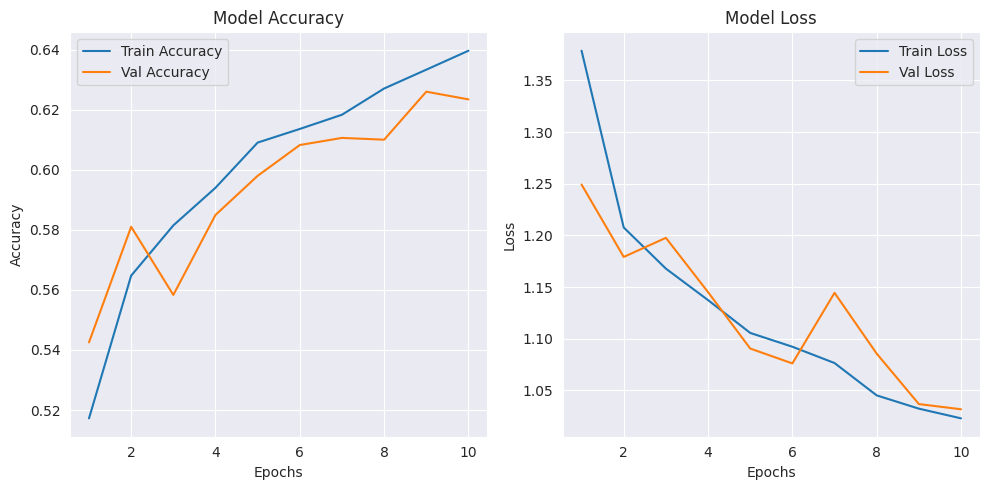

In [15]:
plot_model_history(history)

In [19]:
import itertools

# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else int(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


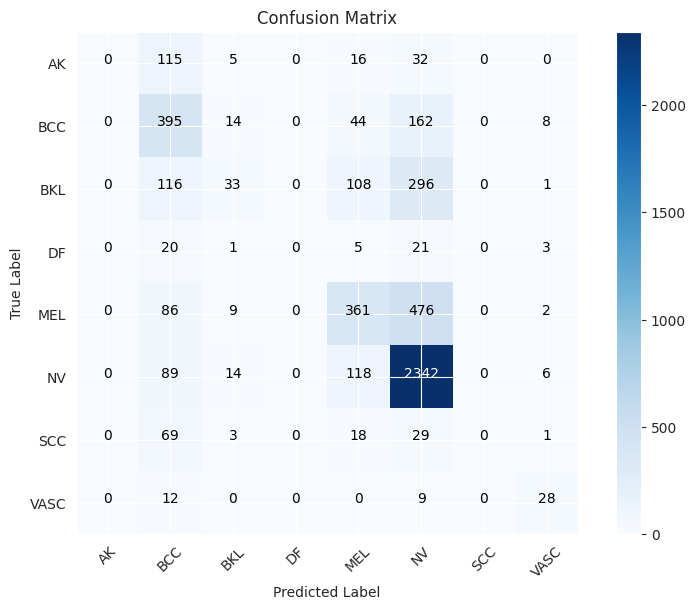

In [20]:
# Predictions
Y_pred =model.predict(X_test_reshaped)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

# Plot confusion matrix using label_encoder for class names
plot_confusion_matrix(cm, classes=label_encoder.classes_)

In [9]:
model = build_googlenet(input_shape=(75, 75, 3), num_classes=8)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 75, 75, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 38, 38, 64)     │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 19, 19, 64)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 19, 19, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 19, 19, 192)    │        110,784 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 10, 10, 192)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 10, 10, 96)     │         18,528 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 10, 10, 16)     │          3,088 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 10, 10, 192)    │              0 │ max_pooling2d_1[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 10, 10, 64)     │         12,352 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 10, 10, 128)    │        110,720 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 10, 10, 32)     │         12,832 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 10, 10, 32)     │          6,176 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 10, 10, 256)    │              0 │ conv2d_3[0][0],        │
│                           │                        │                │ conv2d_5[0][0],        │
│                           │                        │                │ conv2d_7[0][0],        │
│                           │                        │                │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 10, 10, 128)    │         32,896 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 10, 10, 32)     │          8,224 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3      

 Total params: 6,006,328 (22.91 MB)

 Trainable params: 6,006,328 (22.91 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [10]:
import json
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define callback
callbacks = [EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)]

# Define input shape & number of classes
input_shape = (75, 75, 3)
num_classes = 8  # Adjust based on your dataset

# Build InceptionV3 Model
def build_inception_v3():
    base_model = InceptionV3(weights=None, include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Train & Save Model
def train_and_save(model, model_name="InceptionV3"):
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test),
                        epochs=10, batch_size=64, callbacks=callbacks)
    
    test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=1)
    print(f"{model_name} Test Accuracy: {test_accuracy * 100:.2f}%")

    # Save model
    model.save(f"{model_name}.h5")

    # Save training history and accuracy in JSON
    history_dict = history.history
    history_dict["test_accuracy"] = test_accuracy  # Store test accuracy separately

    with open(f"{model_name}_history.json", "w") as f:
        json.dump(history_dict, f)

    return history, test_accuracy

# Train and Save InceptionV3
model = build_inception_v3()
history, accuracy = train_and_save(model, "InceptionV3")

# Save Accuracy Separately
accuracy_data = {"InceptionV3": accuracy}
with open("model_accuracies.json", "w") as f:
    json.dump(accuracy_data, f)

# Plot & Save Accuracy Graph
plt.figure(figsize=(6, 4))
plt.bar(["InceptionV3"], [accuracy * 100], color="green")
plt.xlabel("Model")
plt.ylabel("Test Accuracy (%)")
plt.title("InceptionV3 Accuracy")
plt.savefig("inceptionv3_accuracy.png")  # Save plot as an image file
plt.show()


ValueError: Invalid dtype: str128

===================================

In [20]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dir = '/kaggle/input/isic-2019-skin-lesion-images-for-classification/'


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 202MB/s]


KeyboardInterrupt: 

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, 
                                     MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Add, Concatenate)

def residual_block(x, filters):
    shortcut = x  # Save input for residual connection
    
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Add()([x, shortcut])  # Residual connection
    x = Activation('relu')(x)
    return x

def dense_block(x, filters):
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    conv2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    
    x = Concatenate()([x, conv2])  # Dense connection
    return x

def build_novel_cnn(input_shape=(75, 75, 3), num_classes=8):
    inputs = Input(shape=input_shape)
    
    # Initial Convolution
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    # Residual & Dense Blocks
    x = residual_block(x, 64)
    x = dense_block(x, 64)
    x = MaxPooling2D((2, 2))(x)
    
    x = residual_block(x, 128)
    x = dense_block(x, 128)
    x = MaxPooling2D((2, 2))(x)
    
    x = residual_block(x, 256)
    x = dense_block(x, 256)
    x = MaxPooling2D((2, 2))(x)
    
    # Global Pooling & Fully Connected Layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, x, name="Novel_CNN")
    return model

# Create the model
novel_cnn = build_novel_cnn()
novel_cnn.summary()


Model: "Novel_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 75, 75, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 38, 38, 64)     │          9,472 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_21          │ (None, 18, 18, 64)     │              0 │ conv2d_35[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 18, 18, 64)     │         36,928 │ max_pooling2d_21[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 18, 18, 64)     │            256 │ conv2d_36[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 18, 18, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 18, 18, 64)     │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 18, 18, 64)     │            256 │ conv2d_37[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 18, 18, 64)     │              0 │ batch_normalization_1… │
│                           │                        │                │ max_pooling2d_21[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 18, 18, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 18, 18, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 18, 18, 64)     │         36,928 │ conv2d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 18, 18, 128)    │              0 │ activation_1[0][0],    │
│                           │                        │                │ conv2d_39[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_22          │ (None, 9, 9, 128)      │              0 │ concatenate[0][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 9, 9, 128)      │        147,584 │ max_pooling2d_22[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 9, 9, 128)      │            512 │ conv2d_40[0][0]        │
│ (BatchNormalization) 

 Total params: 3,378,184 (12.89 MB)

 Trainable params: 3,376,392 (12.88 MB)

 Non-trainable params: 1,792 (7.00 KB)